In [ ]:
import spacy
import numpy as np
import re
from spacy import displacy
from spacy.matcher import Matcher
import spacy
from spacy.tokens import Span
from collections import Counter, defaultdict
import math

#Entity Ruler

In [ ]:
nlp  = spacy.load("en_core_web_sm")
text = "A short ball, out OUT! what a wonderful wicket by Mohammed Shami through the middle wicket."
doc = nlp(text)

In [ ]:
for ent in doc.ents:
  print(ent.text, ent.label_)

Mohammed Shami PERSON


In [ ]:
ruler = nlp.add_pipe("entity_ruler", before = "ner")

In [ ]:
patterns = [
    {"label": "EVENT", "pattern": "OUT"}
]

In [ ]:
ruler.add_patterns(patterns)

In [ ]:
doc2 = nlp(text)
for ent in doc2.ents:
  print(ent.text, ent.label_)

OUT EVENT
Mohammed Shami PERSON


#MATCHER

In [ ]:
with open("/content/trial_comm.txt", "r") as f:
  text = f.read()

In [ ]:
nlp  = spacy.load("en_core_web_sm")
doc = nlp(text)
for token in doc[:20]:
  print(token, "\t\t", token.pos_)

In [ ]:
speak_lemma = ['to']
matcher = Matcher(nlp.vocab)
pattern = [{"ORTH": ":"},
           {"IS_ALPHA": True, "OP": "+"},
           {"POS": "ADP", "LEMMA": {"IN": speak_lemma}},
           {"POS": "PROPN", "OP": "+"},
           ]
matcher.add("PROPER_NOUN", [pattern], greedy = "LONGEST")
matches = matcher(doc)
matches.sort(key = lambda x: x[1])
print(len(matches))
for match in matches:
  print(match, doc[match[1]:match[2]])

7
(451313080118390996, 30, 36) : Jasprit Bumrah to Jhye Richardson
(451313080118390996, 114, 120) : Jasprit Bumrah to Jhye Richardson
(451313080118390996, 172, 178) : Jasprit Bumrah to Nathan Lyon
(451313080118390996, 226, 232) : Jasprit Bumrah to Jhye Richardson
(451313080118390996, 271, 277) : Jasprit Bumrah to Jhye Richardson
(451313080118390996, 307, 313) : Jasprit Bumrah to Jhye Richardson
(451313080118390996, 366, 372) : Bhuvneshwar Kumar to Nathan Lyon


#Extraction

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Define custom preprocessing function
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in ENGLISH_STOP_WORDS)

    return text

# Read data from the file
with open("/content/comm.txt", "r") as f:
    documents = f.read()

# Preprocess the documents using the custom preprocessing function
documents = preprocess_text(documents)

# Initialize the TfidfVectorizer with custom parameters
vectorizer = TfidfVectorizer()

# Fit the model and transform the preprocessed documents into TF-IDF vectors
tfidf_matrix = vectorizer.fit_transform([documents])

# Get feature names to use as columns in the DataFrame
feature_names = vectorizer.get_feature_names_out()

# Convert the tfidf_matrix to a dense matrix, then to a DataFrame
import pandas as pd
tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns=feature_names)

# Display the DataFrame
print(tfidf_df)


      aaron  absolute    action     added  adjusts     ahead       air  \
0  0.074643  0.001265  0.001265  0.003795  0.00253  0.001265  0.008856   

       alex   allows     anger  ...      wide    wided    width    willow  \
0  0.012651  0.00253  0.001265  ...  0.020242  0.00253  0.00253  0.001265   

      works     world    wrists     yadav       yes   yorker  
0  0.031629  0.001265  0.001265  0.073378  0.001265  0.00253  

[1 rows x 714 columns]


#CUSTOM COMPOMENTS

In [ ]:
with open("/content/comm.txt", "r") as f:
  commentary = f.read()

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
# Initialize a defaultdict to store counts, runs, and ball counts
bowler_stats = defaultdict(lambda: {'wickets': 0, 'dot_balls': 0, 'runs_given': 0, 'balls_bowled': 0})

# Existing regex patterns
wicket_pattern = r"Delivery: (\w+ \w+) to \w+ \w+\sCommentary:.*?OUT!"
dot_ball_pattern = r"Delivery: (\w+ \w+) to \w+ \w+\sCommentary:.*?no run,"
runs_pattern = r"Delivery: (\w+ \w+) to \w+ \w+\sCommentary:.*?(SIX|FOUR|wide, 1 run|[0-9]+ run)"
delivery_pattern = r"Delivery: (\w+ \w+) to"

# Count deliveries to calculate overs
for match in re.finditer(delivery_pattern, commentary):
    bowler = match.group(1)
    bowler_stats[bowler]['balls_bowled'] += 1

# Find and count wickets
for match in re.finditer(wicket_pattern, commentary, re.DOTALL):
    bowler = match.group(1)
    bowler_stats[bowler]['wickets'] += 1

# Find and count dot balls
for match in re.finditer(dot_ball_pattern, commentary, re.DOTALL):
    bowler = match.group(1)
    bowler_stats[bowler]['dot_balls'] += 1

# Find and count runs
for match in re.finditer(runs_pattern, commentary, re.DOTALL):
    bowler = match.group(1)
    run_phrase = match.group(2)
    if run_phrase == "SIX":
        runs = 6
    elif run_phrase == "FOUR":
        runs = 4
    elif run_phrase.startswith("wide"):
        runs = 1  # Considering wides that contribute a run
    else:
        # Assuming the format "<number> run" for other runs
        runs = int(re.search(r'\d+', run_phrase).group())
    bowler_stats[bowler]['runs_given'] += runs

# Format the output as a list of lists including overs bowled
data = [[
    bowler,
    stats['wickets'],
    stats['dot_balls'],
    stats['runs_given'],
    math.ceil(stats['balls_bowled'] / 6)
] for bowler, stats in bowler_stats.items()]

print(data)

[['Jasprit Bumrah', 2, 34, 49, 10], ['Bhuvneshwar Kumar', 3, 31, 43, 10], ['Mohammed Shami', 2, 25, 59, 9], ['Kuldeep Yadav', 0, 25, 63, 10], ['Ravindra Jadeja', 2, 27, 43, 10], ['Kedar Jadhav', 0, 1, 8, 1]]


In [ ]:
# Create the EntityRuler component and add it to the pipeline
ruler = nlp.add_pipe("entity_ruler", before="ner")

# Define patterns for each of the cricket actions you mentioned
patterns = [
    {"label": "CRICKET_ACTION", "pattern": "OUT"},
    {"label": "CRICKET_ACTION", "pattern": "SIX"},
    {"label": "CRICKET_ACTION", "pattern": "FOUR"},
    {"label": "CRICKET_ACTION", "pattern": "dot ball"},
    # Add more patterns as needed
]

# Add the patterns to the ruler
ruler.add_patterns(patterns)

# Example text
text = "He hit a SIX and then a FOUR before getting OUT. Another delivery was a dot ball."

# Process the text
doc = nlp(text)

# Print entities in the text
for ent in doc.ents:
    print(f"{ent.text} - {ent.label_}")

SIX - CRICKET_ACTION
FOUR - CRICKET_ACTION
OUT - CRICKET_ACTION
dot ball - CRICKET_ACTION


In [ ]:
# Assign point values (You can adjust these values based on your preference)
points_per_wicket = 25
points_per_dot_ball = 1
points_deducted_per_run_given = -0.5

# Calculate scores for each bowler
for bowler_data in data:
    bowler, wickets, dot_balls, runs_given, overs_bowled = bowler_data
    score = (wickets * points_per_wicket + dot_balls * points_per_dot_ball + runs_given * points_deducted_per_run_given)

    # Normalize score by the number of balls bowled (assuming 6 balls per over for normalization)
    balls_bowled = overs_bowled * 6
    normalized_score = score / balls_bowled if balls_bowled > 0 else 0

    # Update bowler data with calculated score
    bowler_data.append(normalized_score)

# Sort bowlers by their normalized score in descending order to get the preference order
preference_order = sorted(data, key=lambda x: x[-1], reverse=True)

# Displaying the preference order
for idx, bowler_data in enumerate(preference_order, start=1):
    bowler, wickets, dot_balls, runs_given, overs_bowled, score = bowler_data
    print(f"Rank {idx}: {bowler}, Score: {score:.2f} (Wickets: {wickets}, Dot Balls: {dot_balls}, Runs Given: {runs_given}, Overs Bowled: {overs_bowled})")

Rank 1: Bhuvneshwar Kumar, Score: 1.41 (Wickets: 3, Dot Balls: 31, Runs Given: 43, Overs Bowled: 10)
Rank 2: Jasprit Bumrah, Score: 0.99 (Wickets: 2, Dot Balls: 34, Runs Given: 49, Overs Bowled: 10)
Rank 3: Ravindra Jadeja, Score: 0.93 (Wickets: 2, Dot Balls: 27, Runs Given: 43, Overs Bowled: 10)
Rank 4: Mohammed Shami, Score: 0.84 (Wickets: 2, Dot Balls: 25, Runs Given: 59, Overs Bowled: 9)
Rank 5: Kuldeep Yadav, Score: -0.11 (Wickets: 0, Dot Balls: 25, Runs Given: 63, Overs Bowled: 10)
Rank 6: Kedar Jadhav, Score: -0.50 (Wickets: 0, Dot Balls: 1, Runs Given: 8, Overs Bowled: 1)


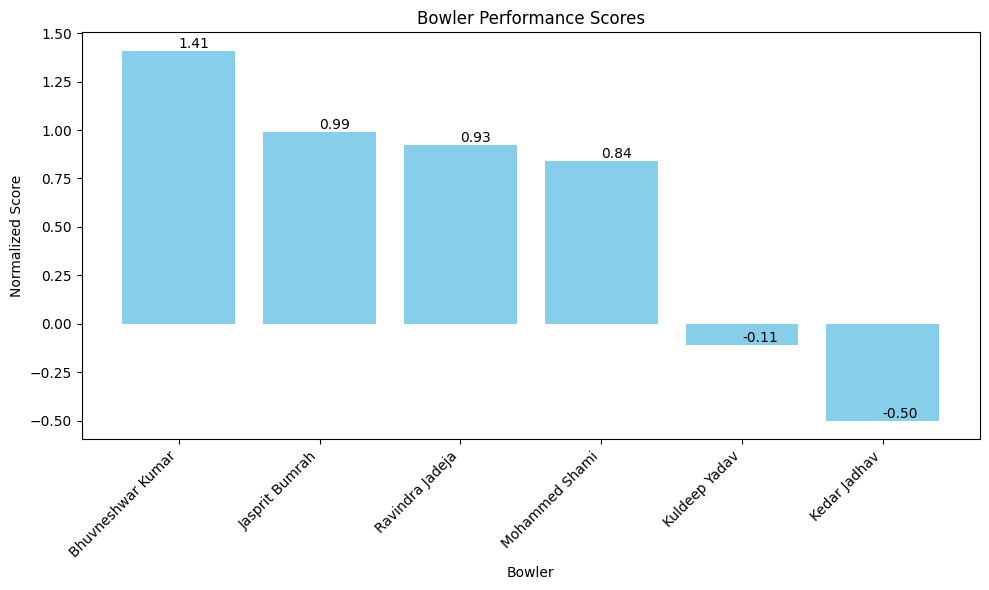

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'preference_order' is your sorted list containing bowler data
bowlers = [item[0] for item in preference_order]  # Extract bowler names
scores = [item[-1] for item in preference_order]  # Extract calculated scores

# Create a bar chart
plt.figure(figsize=(10, 6))  # Set the figure size
bars = plt.bar(bowlers, scores, color='skyblue')  # Create a bar chart

# Add titles and labels
plt.title('Bowler Performance Scores')
plt.xlabel('Bowler')
plt.ylabel('Normalized Score')

# Rotate the bowler names on x-axis for better readability
plt.xticks(rotation=45, ha="right")

# Adding value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f"{yval:.2f}", va='bottom')  # va='bottom' to make it easier to read

# Show plot
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()